In [1]:
#!pip install xlrd
import numpy as np
import pandas as pd
import sys
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_diabetes
from sklearn.datasets import load_iris


X_raw_diab, _ = load_diabetes(as_frame=True, return_X_y=True)

X_raw_breast_cancer, _ = load_breast_cancer(as_frame=True, return_X_y=True)
X_raw_california, _ = fetch_california_housing(as_frame=True, return_X_y=True)
X_raw_iris, y_raw_iris = load_iris(as_frame=True, return_X_y=True)

climate_model_samples = np.loadtxt(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00252/pop_failures.dat",
    skiprows=1,
)
climate_model_df = pd.DataFrame(climate_model_samples)

raw_datasets = {
    "spam": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
    ),
    "parkinsons": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data",
        sep=",",
    ),
    "wine_red": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
        sep=";",
    ),
    "wine_white": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",
        sep=";",
    ),
    "compression": pd.read_excel(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
    ),
    "diabetes": X_raw_diab,
    "ionosphere": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data",
        sep=",",
        header=None,
    ),
    "letter": pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data",
        header=None,
    ),
}

In [2]:
from benchmark_imputation import simulate_scenarios
from hyperimpute.plugins.imputers import Imputers
import warnings
import pandas as pd

import hyperimpute.logger as log

# log.add(sink=sys.stderr, level="INFO")

imputers = Imputers()

warnings.filterwarnings("ignore")

Instructions for updating:
non-resource variables are not supported in the long term


## Convergence plots

In [3]:
from hyperimpute.plugins.utils.metrics import RMSE
from benchmark_imputation import ws_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from time import time
from hyperimpute.utils.distributions import enable_reproducible_results


def get_imputer(cbk):
    return imputers.get(
        "hyperimpute",
        optimizer="hyperband",
        inner_loop_hook=cbk,
        select_lazy=False,
    )


def evaluate_convergence_for_dataset(
    name: str,
    X_raw: pd.DataFrame,
    scenarios: list = ["MAR"],
    miss_pct: list = [0.3],
    debug: bool = True,
):
    imputation_scenarios = simulate_scenarios(
        X_raw, column_limit=10, sample_columns=False
    )

    out = {}
    traces = {}
    for scenario in scenarios:
        out[scenario] = {}
        traces[scenario] = {}

        for missingness in miss_pct:

            try:
                x, x_miss, mask = imputation_scenarios[scenario][missingness]

                wass_scores = []
                rmse_scores = []

                def hook(outer_it, Xt):
                    nonlocal rmse_scores
                    nonlocal wass_scores
                    distribution_score = ws_score(Xt, x)
                    rmse_score = RMSE(np.asarray(Xt), np.asarray(x), np.asarray(mask))

                    wass_scores.append(distribution_score)
                    rmse_scores.append(rmse_score)
                    # print(outer_it, distribution_score, rmse_score)

                model = get_imputer(hook)
                model.fit_transform(x_miss.copy())

                full_trace = model.trace()
                model_trace = full_trace["models"]
                trace = full_trace["objective"]

                max_wait = len(wass_scores)

                for mod_idx in trace:
                    if len(trace[mod_idx]) < max_wait:
                        trace[mod_idx] += [trace[mod_idx][-1]] * (
                            max_wait - len(trace[mod_idx])
                        )

                for mod_idx in trace:
                    arr = np.asarray(trace[mod_idx])
                    if arr[0] > 0:  # AUCROC
                        arr = 1 - arr
                    else:  # -RMSE
                        arr = -arr

                    trace[mod_idx] = arr

                scores = []
                for mod_idx in trace:
                    score_len = len(trace[mod_idx])
                    break

                for epoch in range(score_len):
                    epoch_score = 0
                    for mod_idx in trace:
                        epoch_score += trace[mod_idx][epoch]
                    scores.append(epoch_score)
                    print(epoch, epoch_score)
            except BaseException as e:
                raise e
                print("scenario failed", str(e))
                continue
    return scores, wass_scores, rmse_scores, model_trace


def evaluate_dataset(dataset, scenario, miss, seed: int = 0):
    enable_reproducible_results(seed)

    start = time()
    df = raw_datasets[dataset]
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = LabelEncoder().fit_transform(df[col])

    (
        optimizer_scores,
        wass_scores,
        rmse_scores,
        model_trace,
    ) = evaluate_convergence_for_dataset(
        dataset, df, scenarios=[scenario], miss_pct=[miss]
    )

    print(f"evaluation {dataset} {scenario} {miss} took {time() - start}")
    return optimizer_scores, wass_scores, rmse_scores, model_trace

In [ ]:
import json

from joblib import Parallel, delayed

dispatcher = Parallel(n_jobs=2)
repeats = 10

results = {}

full_output = {}
for dataset in raw_datasets:
    results[dataset] = {}
    scenario = "MAR"
    miss = 0.3

    print("eval dataset", dataset)
    results[dataset][scenario] = {}
    try:
        full_opt_scores = []
        full_was_scores = []
        full_rmse_scores = []
        full_trace = []

        bench_res = dispatcher(
            delayed(evaluate_dataset)(dataset, scenario, miss, seed=i)
            for i in range(repeats)
        )

        for optimizer_scores, wass_scores, rmse_scores, traces in bench_res:
            full_opt_scores.append(optimizer_scores)
            full_was_scores.append(wass_scores)
            full_rmse_scores.append(rmse_scores)
            full_trace.append(traces)

        full_output[dataset] = {
            "objective": full_opt_scores,
            "mwd": full_was_scores,
            "rmse": full_rmse_scores,
            "model_trace": full_trace,
        }
        results[dataset][scenario][miss] = (optimizer_scores, wass_scores, rmse_scores)
    except BaseException as e:
        print("scenario failed", dataset, scenario, e)
        raise e

In [5]:
with open("general_results/convergence_traces.json", "w") as f:
    json.dump(full_output, f)

## Convergence plots

In [6]:
from pathlib import Path

output_dir = Path("diagrams/convergence_v2")


def plot_single_diagram(ax, title: str, data: list, min_trace_length: int):
    trace_arr = np.concatenate([np.array([i[:min_trace_length]]) for i in data], axis=0)
    trace_mean, trace_std = np.mean(trace_arr, axis=0), np.std(trace_arr, axis=0)

    ax.plot(list(range(min_trace_length)), trace_mean)
    ax.fill_between(
        list(range(min_trace_length)),
        trace_mean - trace_std,
        trace_mean + trace_std,
        color="gray",
        alpha=0.2,
    )
    ax.set_xticks(list(range(0, min_trace_length, 4)), fontsize=14)

    ax.set_title(title, fontweight="bold", fontsize=16)


def plot_convergence(scenario, miss, data):
    plt.style.use("seaborn-whitegrid")
    for dataset in data:
        print(dataset)
        min_trace_length = min(map(len, data[dataset]["objective"]))
        avg_trace_len = int(np.mean(list(map(len, data[dataset]["objective"]))))
        for plot in ["objective", "rmse", "mwd"]:
            for idx, res in enumerate(data[dataset][plot]):
                if len(res) < avg_trace_len:
                    data[dataset][plot][idx] += [res[-1]] * (avg_trace_len - len(res))

        fig, axs = plt.subplots(1, 3, figsize=(15, 4))

        for i, plot in enumerate(["objective", "rmse", "mwd"]):
            plot_single_diagram(
                axs[i],
                title=plot,
                data=data[dataset][plot],
                min_trace_length=avg_trace_len,
            )
        fig.supxlabel("Iterations", fontsize=16)

        plt.savefig(output_dir / f"convergence_{scenario}_{miss}_{dataset}.png")

        plt.tight_layout()
        plt.show()

spam


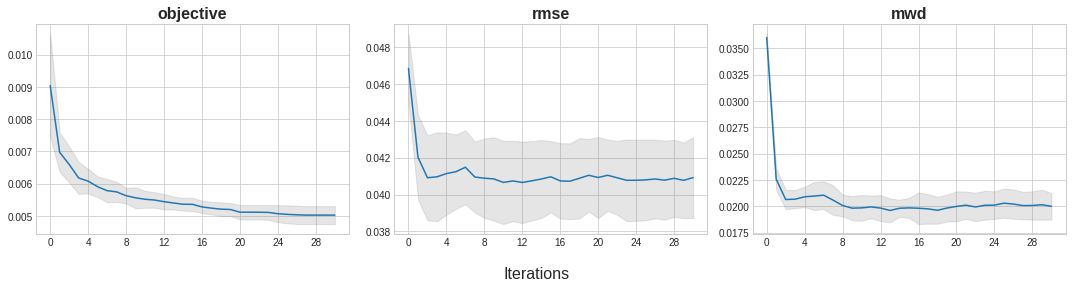

parkinsons


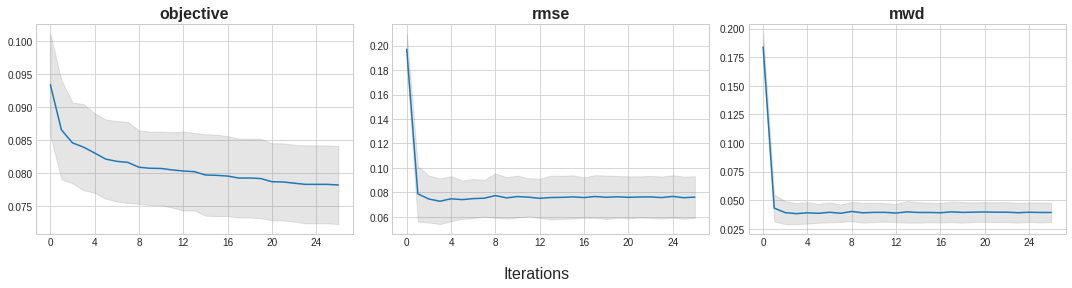

wine_red


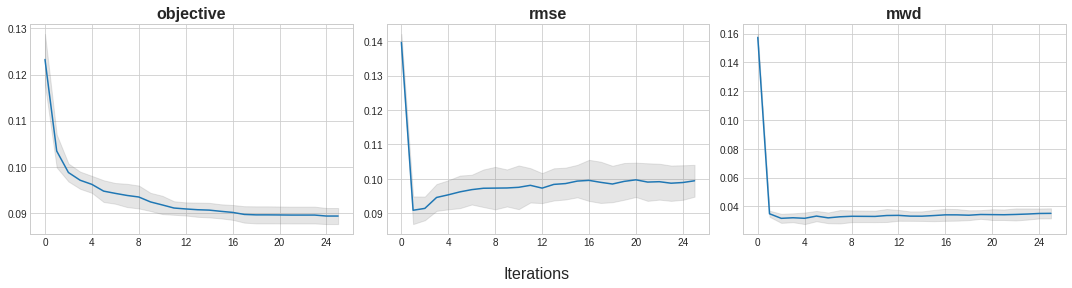

wine_white


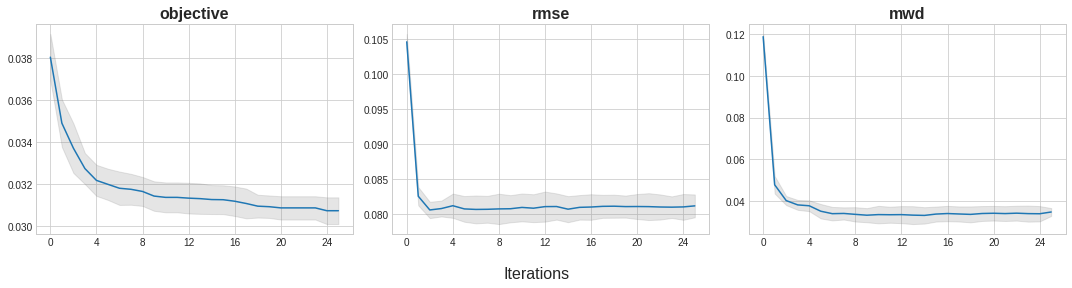

compression


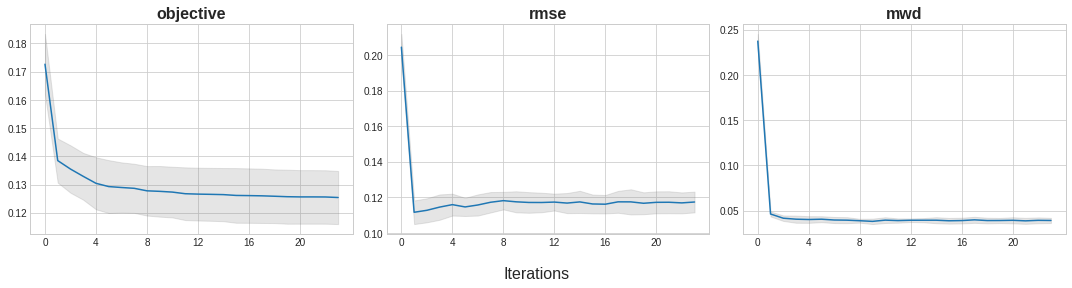

diabetes


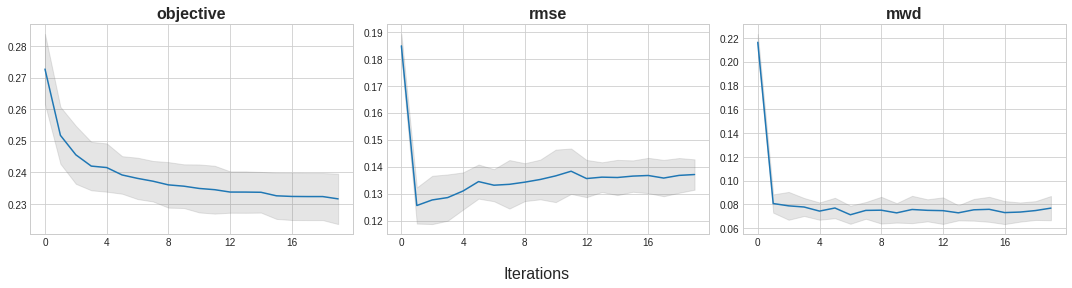

In [7]:
with open("general_results/convergence_traces.json") as f:
    full_output = json.load(f)

plot_convergence("MAR", 0.3, full_output)